In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.transforms import v2
import os
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

C:\Users\gsnik\AppData\Roaming\Python\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\gsnik\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

# Globals

In [2]:
USE_GPU = True
dtype = torch.float32
print_every = 1000
image_dim = 512

device = 'cuda' if (USE_GPU and torch.cuda.is_available()) else 'cpu'
print("Using:", device)

Using: cuda


# Utils

In [3]:
#Don't need to run this unless you are computing for a new dataset

def calc_mean_std(loader):
    '''
    Calculates the Mean and Std of image dataset for each input channel.

    Assumptions: The dataset has not been Transformed in any way
    other than torchvision.transforms.ToTensor()

    Input: Dataloader using minibatches of shape N x C x H x W

    Output: Two C-vectors indicating mean and std
    '''
    avg = 0
    var = 0
    for e in range(1): #only 1 epoch
        #for t, (x, y) in enumerate(loader):
        for t, x in enumerate(loader):
            # t = batch number (ex. 0-999 for N = 50,000 and loader batch_size = 50)
            # x = 4D tensor batch data (N x C x H x W)
            # y = labels/target for batch
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)

            this_avg = torch.mean(x, dim=(0,2,3))
            if t == 0:
                avg = this_avg
            else:
                avg = (t/(t+1))*avg + (1/(t+1))*this_avg

    avg_broad = avg.reshape((1,3,1,1))
    for e in range(1):
        #for t, (x, y) in enumerate(loader):
        for t, x in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            zero_mean = x - avg_broad
            this_var = torch.mean(torch.mul(zero_mean, zero_mean), dim=(0,2,3))
            if t == 0:
                var = this_var
            else:
                var = (t/(t+1))*var + (1/(t+1))*this_var


    return avg, torch.sqrt(var)

#cifar100_mean, cifar100_std = calc_mean_std(loader_sandbox)
#print("Mean: " + str(cifar100_mean))
#print("Std: " + str(cifar100_std))

# Data

## Transforms

In [4]:
class DilationTransform(nn.Module):
    def __init__(self, min_kernel, max_kernel) -> None:
        super().__init__()
        self.min_kernel = min_kernel
        self.max_kernel = max_kernel

    def forward(self, input):
        kernel_size = torch.randint(self.min_kernel, self.max_kernel, size=(1,1)).item()
        # print(kernel_size)
        N, C, H, W = input.shape
        kernel = torch.ones((C, C, kernel_size, kernel_size))
        out = F.conv2d(input=input, weight=kernel, padding=kernel_size//2, groups=C)
        out = torch.clamp(out, 0, 1)
        return out

In [5]:
class InvertMaskTransform(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mask):
        return 1 - mask

In [6]:
mask_transforms = v2.Compose([
    InvertMaskTransform(),
    DilationTransform(7, 42),
    v2.RandomCrop(image_dim),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    InvertMaskTransform()
])

In [7]:
celeb_mean = (131.7364/255.0, 106.1529/255.0,  92.5201/255.0)
celeb_std  = (77.2750/255.0, 70.0117/255.0, 68.6962/255.0)

image_transforms = v2.Compose([
    T.Normalize(celeb_mean, celeb_std),
    T.Resize(image_dim, antialias=True)
])

## Datasets

In [8]:
class CelebA_HQ(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len([name for name in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, name))])

    def __getitem__(self, idx):
        img_path = self.img_dir + str(idx) + ".jpg"
        image = read_image(img_path).type(dtype)  # Already comes out as a tensor, don't need to use T.ToTensor()
        image = image/255.0  #convert from 0-255 to 0-1
        if self.transform:
            image = self.transform(image)
        return image


In [9]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None, preproc=False):
        self.path = path
        self.len = len(os.listdir(path))
        self.transforms = transform
        self.preproc = preproc

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        assert idx < self.len, f"Index {idx} is bigger than the number of elements {self.len}"

        if self.preproc:
            img_path = os.path.join(self.path, f"{idx}.png")
            img = plt.imread(img_path)
            H, W, C = img.shape
            if self.transforms is not None:
                tensorized = torch.tensor(img).permute(2,0,1).view((1,C,H,W))
                return self.transforms(tensorized).squeeze(1).expand(3, -1, -1)
            else:
                return torch.tensor(img).permute(2,0,1)
        else:
            img_path = os.path.join(self.path, f"{idx:05}.png")
            img = plt.imread(img_path)
            H, W = img.shape
            if self.transforms is not None:
                return self.transforms(torch.tensor(img).view((1, 1, H, W))).squeeze(1).expand(3, -1, -1)
            else:
                return torch.tensor(img).view((1, 1, H, W)).squeeze(1).expand(3, -1, -1)

In [10]:
celeb_data = CelebA_HQ("./CelebA-HQ-img/", transform=image_transforms)
#celeb_data = CelebA_HQ(".\\Datasets\\CelebAMask-HQ\\CelebA-HQ-img\\", transform=image_transforms) #Christian local

In [11]:
mask_dataset = MaskDataset('./irregular_mask/disocclusion_img_mask', transform=mask_transforms)
#mask_dataset = MaskDataset('.\\Datasets\\irregular_mask\\disocclusion_img_mask', transform=mask_transforms) #Christian local

mask_preprocset = MaskDataset('.\\Datasets\\masks_preprocessed', preproc=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.\\Datasets\\masks_preprocessed'

In [ ]:
# Pre-process Masks
#from torchvision.utils import save_image

'''
mask_loader_process = DataLoader(mask_dataset, batch_size=1, num_workers=4, sampler=sampler.SubsetRandomSampler(range(39000,43000)))
img_num = 27729 # Controls the saved file name
num_cells = 512*512*3
for t, x in enumerate(mask_loader_process):
        N, C, H, W, = x.shape
        x = x.reshape(C,H,W) # N=1
        mask_open = torch.sum(x)/num_cells # How much of the original image is visible
        if mask_open > 0.29 and mask_open < 0.965:
            save_image(x, './Datasets/masks_preprocessed/'+str(img_num)+'.png')
            img_num += 1
        if t % 1000 == 0:
            print(t)

'''

## DataLoaders

In [59]:
NUM_TRAIN  = 26900
NUM_VAL    = 600
NUM_CELEB  = 30000
batch_size = 4
n_workers = 0  # Should use positive integer on Datahub. Use zero for local or it will "exited unexpectedly"


loader_train = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

loader_test = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL, NUM_CELEB)))

In [60]:
mask_loader_train = DataLoader(mask_preprocset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(1,30001)))

mask_loader_val = DataLoader(mask_preprocset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(30001, 31201)))

mask_loader_test = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL+1, 50000)))

NameError: name 'mask_preprocset' is not defined

In [33]:
# Playing with Dataloader

'''
m_train = next(iter(mask_loader_train))
m_test  = next(iter(mask_loader_test))

print(m_train.type)
print(m_train.shape)
plt.imshow(m_train[0].permute(1,2,0))
print(m_test.type)
print(m_test.shape)
#plt.imshow(m_test[0].permute(1,2,0))
'''

'\nm_train = next(iter(mask_loader_train))\nm_test  = next(iter(mask_loader_test))\n\nprint(m_train.type)\nprint(m_train.shape)\nplt.imshow(m_train[0].permute(1,2,0))\nprint(m_test.type)\nprint(m_test.shape)\n#plt.imshow(m_test[0].permute(1,2,0))\n'

# Model

In [15]:
class PConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding = 0, batch_norm=True, activation='relu', A=0.0) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.A = A
        assert self.A >= 0.0 and self.A < 1, f"Hyperparameter must take value between 0 and 1"
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

        self.bn = nn.Identity()
        if batch_norm:
            self.bn = nn.BatchNorm2d(num_features=out_channels)
            
        self.act = nn.Identity()
        if activation == 'leaky_relu':
            self.act = nn.LeakyReLU(0.2)
        elif activation == 'relu':
            self.act = nn.ReLU()

    def forward(self, x, mask):
        assert x.shape == mask.shape, f"Shape of x {x.shape} doesn't match shape of mask {mask.shape}"
        
        # Pad x and mask
        x1 = F.pad(x, pad=[self.padding]*4)
        mask1 = F.pad(mask, pad=[self.padding]*4)

        # Everything mask
        sum_one = mask.shape[1] * self.kernel_size * self.kernel_size
        mask_kernel = torch.ones((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)).to(device)
        # print(mask1.dtype, mask_kernel.dtype)
        sum_mask = F.conv2d(mask1, weight=mask_kernel, stride=self.stride)
        out_mask = (sum_mask > self.A*sum_one).type(dtype)

        sum_mask = sum_mask.clamp(min=1e-10)

        bias = self.conv.bias.view(1, -1, 1, 1)
        y = self.conv(x1 * mask1)
        y = (y - bias) * (sum_one / sum_mask) + bias      
        y = self.act(self.bn(y))
        return y, out_mask

In [16]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding = 0, batch_norm=True, activation='relu') -> None:
        super().__init__()
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.pconv = PConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, batch_norm=batch_norm, activation=activation)

    def forward(self, x, mask, x2, mask2):
        x1 = self.upsample(x)
        mask1 = F.interpolate(mask, scale_factor=2, mode='nearest')
        # mask1 = F.upsample_nearest(mask, scale_factor=2)
        x3, mask3 = torch.cat([x1, x2], dim=1), torch.cat([mask1, mask2], dim=1)
        return self.pconv(x3, mask3)

In [17]:
class PConvNet(nn.Module):
    def __init__(self, A=0.0):
        super().__init__()
        self.pconv1 = PConvBlock(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, batch_norm=False, activation='relu', A=A)
        self.pconv2 = PConvBlock(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2, batch_norm=True, activation='relu', A=A)
        self.pconv3 = PConvBlock(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2, batch_norm=True, activation='relu', A=A)
        self.pconv4 = PConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu', A=A)
        self.pconv5 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu', A=A)
        self.pconv6 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu', A=A)
        self.pconv7 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu', A=A)
        self.pconv8 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu', A=A)

        self.up1 = Up(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1, batch_norm=True, activation='leaky_relu')
        self.up2 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up3 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up4 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up5 = Up(in_channels=768, out_channels=256, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up6 = Up(in_channels=384, out_channels=128, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up7 = Up(in_channels=192, out_channels=64, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up8 = Up(in_channels=67, out_channels=3, kernel_size=3, stride=1, padding=1, batch_norm=False, activation=None)
        
    
    def forward(self, x, mask):
        x1, mask1 = self.pconv1(x, mask)
        x2, mask2 = self.pconv2(x1, mask1)
        x3, mask3 = self.pconv3(x2, mask2)
        x4, mask4 = self.pconv4(x3, mask3)
        x5, mask5 = self.pconv5(x4, mask4)
        x6, mask6 = self.pconv6(x5, mask5)
        x7, mask7 = self.pconv7(x6, mask6)
        x8, mask8 = self.pconv8(x7, mask7)

        _, _m = self.up1(x8, mask8, x7, mask7)
        _, _m = self.up2(_, _m, x6, mask6)
        _, _m = self.up3(_, _m, x5, mask5)
        _, _m = self.up4(_, _m, x4, mask4)
        _, _m = self.up5(_, _m, x3, mask3)
        _, _m = self.up6(_, _m, x2, mask2)
        _, _m = self.up7(_, _m, x1, mask1)
        _, _m = self.up8(_, _m, x, mask)

        return _

# Loss

In [18]:
def get_features(name, features):
        def hook(model, input, output):
            features[name].append(output.detach())
        return hook

In [19]:
class InpaintingLoss(nn.Module):
    def __init__(self, weights, trained_model='vgg') -> None:
        super().__init__()

        self.weights = weights

        self.ref_model = None
        self.ref_model_transforms = []
        self.pool_layers = []

        self.pool_outs = {
            'pool1': [],
            'pool2': [],
            'pool3': []
        }

        if trained_model == 'vgg':
            self._get_vgg_model()

        self.ref_model = self.ref_model.to(device)
        self.ref_model.eval()


    def _get_vgg_model(self) -> None:
        self.ref_model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.ref_model_transforms = T.Compose([
            T.Resize(256, antialias=True),
            T.CenterCrop(224),
            # T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.ref_model.eval()

        self.pool_layers = []
        for layer in (self.ref_model.named_modules()):
            if type(layer[1]) == torch.nn.modules.pooling.MaxPool2d:
                idx = int(layer[0].split('.')[1])
                self.pool_layers.append(idx)

        print("Following Pooling Layers found: ", self.pool_layers)
        print(f"Using 1st three {self.pool_layers[0:3]} for perceptual loss")
        self.pool_layers = self.pool_layers[0:3] # Updating the useful pool layer

        # Adding forward_hooks
        for i, layer_idx in enumerate(self.pool_layers):
            self.ref_model.features[layer_idx].register_forward_hook(get_features(f"pool{i+1}", self.pool_outs))


    def forward(self, input, out, gt, mask):
        '''
        input - N x C x H x W
        out - N x C x H x W
        gt - N x C x H x W
        mask - N x C x H x W (or N x 1 x H x W, if this is the case then cast it to N x C x H x W)
        '''
        assert input.shape == out.shape, "input and output are of different shapes"
        assert out.shape == gt.shape, "out and gt are of different shapes"
        assert out.shape == mask.shape, "out and mask are of different shapes"
        assert len(input.shape) == 4, "Expected shape is N x C x H x W"
        N, C, H, W = input.shape
        
        self.pool_outs['pool1'] = []
        self.pool_outs['pool2'] = []
        self.pool_outs['pool3'] = []

        # Pixel Losses
        N_gt = C * H * W

        loss_hole = torch.norm((out - gt) * (1 - mask), p=1, dim=(1,2,3)) / N_gt
        loss_valid = torch.norm((out - gt) * mask, p=1, dim=(1,2,3)) / N_gt
        # print("Loss Hole: ", loss_hole)
        # print("Loss Valid: ", loss_valid)

        loss_perceptual = 0
        loss_style_out = 0
        loss_style_comp = 0
        with torch.no_grad():
            comp = mask * gt + (1 - mask) * out
            # Do not change this order. DO NOT.
            _ = self.ref_model(self.ref_model_transforms(out))
            _ = self.ref_model(self.ref_model_transforms(gt))
            _ = self.ref_model(self.ref_model_transforms(comp))

            for i in range(len(self.pool_layers)):
                # Perceptual Loss
                phsi = self.pool_outs[f'pool{i+1}']
                phsi_out, phsi_gt, phsi_comp = phsi[0], phsi[1], phsi[2]
                temp_perceptual_loss = 0

                N, C, H, W = phsi_out.shape
                count = C * H * W

                loss_out_gt = torch.norm(phsi_out - phsi_gt, p = 1, dim=(1, 2, 3))
                loss_comp_gt = torch.norm(phsi_comp - phsi_gt, p = 1, dim=(1, 2, 3))
                temp_perceptual_loss = loss_out_gt + loss_comp_gt
                loss_perceptual += (temp_perceptual_loss / count)

                # Loss Style Out and Loss Style Comp
                temp_loss = 0
                phsi_out = phsi_out.view(N, C, -1) @ phsi_out.view(N, C, -1).transpose(1, 2)
                phsi_comp = phsi_comp.view(N, C, -1) @ phsi_comp.view(N, C, -1).transpose(1, 2)
                phsi_gt = phsi_gt.view(N, C, -1) @ phsi_gt.view(N, C, -1).transpose(1, 2)

                temp_loss = torch.norm(phsi_out - phsi_gt, p=1, dim=(1,2))
                loss_style_out += (temp_loss / (count * C * C))

                temp_loss = torch.norm(phsi_comp - phsi_gt, p=1, dim=(1,2))
                loss_style_comp += (temp_loss / (count * C * C))

            comp_temp = torch.zeros_like(comp)
            comp_temp[:, :, :-1, :] = comp_temp[:, :, 1:, :]
            dx = comp_temp - comp
            comp_temp[:, :, :, :-1] = comp_temp[:, :, :, 1:]
            dy = comp_temp - comp

            loss_tv = torch.norm(dx * (1 - mask), p = 1, dim=(1, 2, 3)) + torch.norm(dy * (1 - mask), p=1, dim=(1, 2, 3))
            loss_tv /= N_gt

            # print("Loss Hole: ", loss_hole)
            # print("Loss Valid: ", loss_valid)
            # print("Loss Perceptual: ", loss_perceptual)
            # print("Loss Style Out: ", loss_style_out)
            # print("Loss Style Comp: ", loss_style_comp)
            # print("Loss TV: ", loss_tv)

        total_loss = self.weights['hole'] * loss_hole + self.weights['valid'] * loss_valid + self.weights['perceptual'] * loss_perceptual + \
                        self.weights['style_out'] * loss_style_out + self.weights['style_comp'] * loss_style_comp + self.weights['tv'] * loss_tv

        return total_loss.mean()

# Train and Test Setup

In [20]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename))
        print("Model Overridden with best available saved model")
    else:
        print("No model found")

In [21]:
def evaluate(model, val_dataloader, mask_dataloader, loss_criterion):
    total_loss = 0
    num_samples = 0
    model = model.to(device)
    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x in val_dataloader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU

            mask = next(iter(mask_dataloader))
            mask = mask.to(device, dtype=dtype)
            
            out = model(x, mask)
            loss = loss_criterion(x, out, x, mask)
            
            num_samples += x.size(0)
            total_loss += loss.item()
            # print(x.shape, num_samples, total_loss)

        total_loss = total_loss / num_samples
        print('Val Loss: ', (total_loss))
    return total_loss

In [22]:
def train(model, optimizer, train_dataloader, val_dataloader, train_mask_dataloader, val_mask_dataloader, 
          loss_criterion, epochs=1, finetuning=False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model.train()  # put model into training mode
    if finetuning:
        # turn off BN accumulation in encoder layers
        # by setting train=False
        #model.pconv1.bn.train(False) #pconv1 has batchnorm=False
        model.pconv2.bn.train(False)
        model.pconv3.bn.train(False)
        model.pconv4.bn.train(False)
        model.pconv5.bn.train(False)
        model.pconv6.bn.train(False)
        model.pconv7.bn.train(False)
        model.pconv8.bn.train(False)

    # Tracking
    BN_mean_E2 = model.pconv2.bn.running_mean.detach().cpu().numpy() #Encoder Layer 2
    BN_var_E2  = model.pconv2.bn.running_var.detach().cpu().numpy()
    BN_mean_E7 = model.pconv7.bn.running_mean.detach().cpu().numpy() # Encoder Layer 7
    BN_var_E7  = model.pconv7.bn.running_var.detach().cpu().numpy()
    BN_mean_D2 = model.up2.pconv.bn.running_mean.detach().cpu().numpy() # Decoder Layer 2
    BN_var_D2  = model.up2.pconv.bn.running_var.detach().cpu().numpy()
    BN_mean_D7 = model.up7.pconv.bn.running_mean.detach().cpu().numpy() # Decoder Layer 7
    BN_var_D7  = model.up7.pconv.bn.running_var.detach().cpu().numpy()


    # Checkpointing
    best_model = None
    best_val_loss = 1e15

    for e in range(epochs):
        tic = time.perf_counter()
        for t, x in enumerate(train_dataloader):
            x = x.to(device=device, dtype=dtype)  
            
            mask = next(iter(train_mask_dataloader))
            mask = mask.to(device, dtype=dtype)

            out = model(x, mask)
            loss = loss_criterion(x, out, x, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                val_loss = evaluate(model, val_dataloader, val_mask_dataloader, loss_criterion)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    checkpoint(best_model, "./best_model")
                model.train()  # put model back into to training mode post-validation
                
                E2_flag = False
                E7_flag = False
                D2_flag = False
                D7_flag = False
                if not np.equal(BN_mean_E2, model.pconv2.bn.running_mean.detach().cpu().numpy()).all():
                    E2_flag = True
                if not np.equal(BN_var_E2, model.pconv2.bn.running_var.detach().cpu().numpy()).all():
                    E2_flag = True 
                if E2_flag:
                    print("Encoder Layer 2 BatchNorm running avg changed")
                if not np.equal(BN_mean_E7, model.pconv7.bn.running_mean.detach().cpu().numpy()).all():
                    E7_flag = True
                if not np.equal(BN_var_E7, model.pconv7.bn.running_var.detach().cpu().numpy()).all():
                    E7_flag = True 
                if E7_flag:
                    print("Encoder Layer 7 BatchNorm running avg changed")
                if not np.equal(BN_mean_D2, model.up2.pconv.bn.running_mean.detach().cpu().numpy()).all():
                    D2_flag = True
                if not np.equal(BN_var_D2, model.up2.pconv.bn.running_var.detach().cpu().numpy()).all():
                    D2_flag = True 
                if D2_flag:
                    print("Decoder Layer 2 BatchNorm running avg changed")
                if not np.equal(BN_mean_D7, model.up7.pconv.bn.running_mean.detach().cpu().numpy()).all():
                    D7_flag = True
                if not np.equal(BN_var_D7, model.up7.pconv.bn.running_var.detach().cpu().numpy()).all():
                    D7_flag = True 
                if D7_flag:
                    print("Decoder Layer 7 BatchNorm running avg changed")
                BN_mean_E2 = model.pconv2.bn.running_mean.detach().cpu().numpy()
                BN_var_E2  = model.pconv2.bn.running_var.detach().cpu().numpy()
                BN_mean_E7 = model.pconv7.bn.running_mean.detach().cpu().numpy()
                BN_var_E7  = model.pconv7.bn.running_var.detach().cpu().numpy()
                BN_mean_D2 = model.up2.pconv.bn.running_mean.detach().cpu().numpy()
                BN_var_D2  = model.up2.pconv.bn.running_var.detach().cpu().numpy()
                BN_mean_D7 = model.up7.pconv.bn.running_mean.detach().cpu().numpy()
                BN_var_D7  = model.up7.pconv.bn.running_var.detach().cpu().numpy()
                if finetuning:
                    # turn off BN accumulation in encoder layers
                    # by setting train=False
                    #model.pconv1.bn.train(False) #pconv1 has batchnorm=False
                    model.pconv2.bn.train(False)
                    model.pconv3.bn.train(False)
                    model.pconv4.bn.train(False)
                    model.pconv5.bn.train(False)
                    model.pconv6.bn.train(False)
                    model.pconv7.bn.train(False)
                    model.pconv8.bn.train(False)
                print()
        toc = time.perf_counter()
        print('Epoch %d took %.3f minutes\n' % (e, (toc - tic)/60.0))
        epoch_model = model
        checkpoint(epoch_model, "./epoch_model_"+str(e))

    resume(model, "./best_model")
    return model

# Train

In [23]:
weights = {
    'hole': 6,
    'valid': 1,
    'perceptual': 0.05,
    'style_out': 120,
    'style_comp': 120,
    'tv': 0.1
}

loss_criterion = InpaintingLoss(weights=weights, trained_model='vgg')

Following Pooling Layers found:  [6, 13, 23, 33, 43]
Using 1st three [6, 13, 23] for perceptual loss


In [24]:
#########################

# Scale learning rate based on batch size
# In PConv paper, batch=6, lr = 0.0002
# If using:
# Batch = 3, lr = 0.0001 or 1e-4
# Batch = 2, lr = 0.000066666 or 6.66666e-5
# Batch = 1, lr = 0.000033333 or 3.33333e-5
learning_rate = 0.0001
fine_tuning_rate = 0.00002

epochs = 2  # Assume 1 epoch = 90 minutes
#########################

model = PConvNet(A=0.0)

#resume(model, './best_model')

model = model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
torch.cuda.empty_cache()

model = train(model=model, 
              optimizer=optimizer, 
              train_dataloader=loader_train, 
              val_dataloader=loader_val, 
              train_mask_dataloader=mask_loader_train, 
              val_mask_dataloader=mask_loader_val, 
              loss_criterion=loss_criterion, 
              epochs=epochs, finetuning=False)


# Test

In [ ]:
evaluate(model, loader_test, mask_loader_test, loss_criterion)

# Metrics

In [25]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [26]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Load Unprocessed MaskDataset

In [61]:
mask_loader_train = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(1,30001)))

mask_loader_val = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(30001, 31201)))

mask_loader_test = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL+1, 50000)))

# Visualize Results

In [62]:
resume(model, './best_model_finetune')
model = model.eval()

Model Overridden with best available saved model


In [63]:
imgs, masks = next(iter(loader_test)).to(device), next(iter(mask_loader_test)).to(device)
out = model(imgs, masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

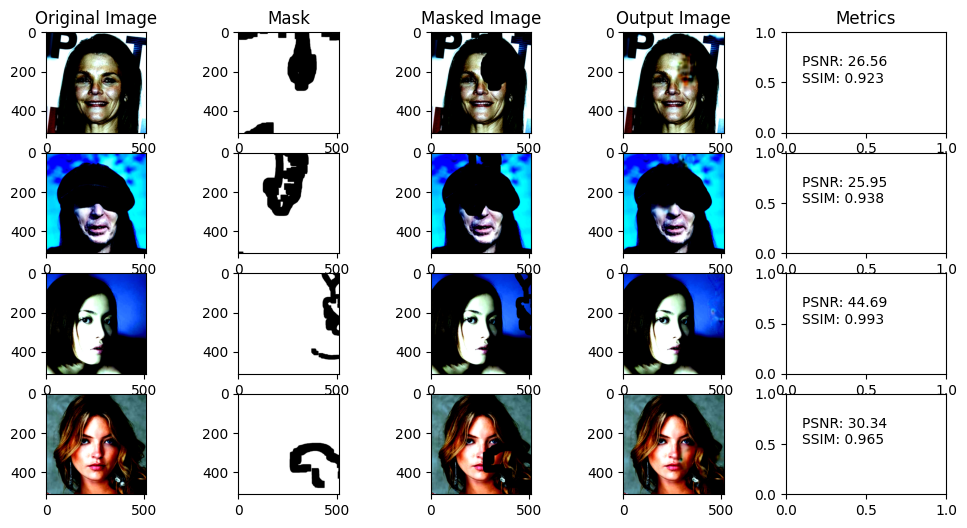

In [64]:
f = plt.figure(figsize=(12, 6))
cols = 5
for idx in range(batch_size):
    temp_img = imgs[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_mask = masks[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_out = out[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    
    plt.subplot(batch_size, cols, cols*idx+1)
    if idx == 0:
        plt.title("Original Image")
    plt.imshow(temp_img)

    plt.subplot(batch_size, cols, cols*idx+2)
    if idx == 0:
        plt.title("Mask")
    plt.imshow(temp_mask)

    plt.subplot(batch_size, cols, cols*idx+3)
    if idx == 0:
        plt.title("Masked Image")
    plt.imshow(temp_mask * temp_img)

    plt.subplot(batch_size, cols, cols*idx+4)
    if idx == 0:
        plt.title("Output Image")
    plt.imshow(temp_out)
    
    psnr = peak_signal_noise_ratio(normalize(temp_img), normalize(temp_out), data_range=1)
    ssim = structural_similarity(normalize(temp_img), normalize(temp_out), channel_axis=2, data_range=1)
    ax = plt.subplot(batch_size, cols, cols*idx+5)
    if idx == 0:
        plt.title("Metrics")
    ax.text(0.1, 0.5, f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")

plt.show()

# Experiments

## Super-resolution

In [41]:
imgs = next(iter(loader_test)).to(device)

In [42]:
downsample_factor = 2
masks = torch.zeros_like(imgs)
masks[:, :, ::downsample_factor, ::downsample_factor] = 1.0

In [43]:
out = model(imgs, masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


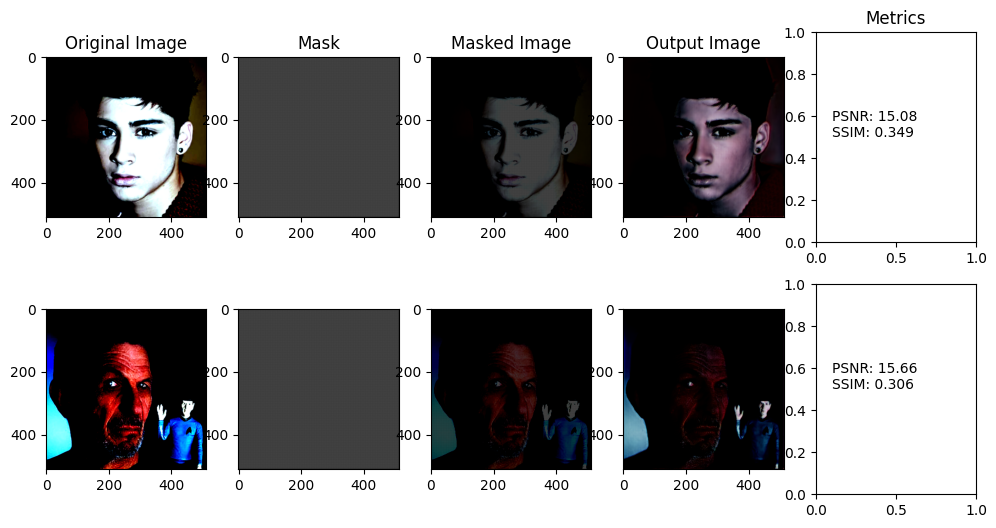

In [44]:
f = plt.figure(figsize=(12, 6))
cols = 5
for idx in range(batch_size):
    temp_img = imgs[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_mask = masks[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_out = out[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    
    plt.subplot(batch_size, cols, cols*idx+1)
    if idx == 0:
        plt.title("Original Image")
    plt.imshow(temp_img)

    plt.subplot(batch_size, cols, cols*idx+2)
    if idx == 0:
        plt.title("Mask")
    plt.imshow(temp_mask)

    plt.subplot(batch_size, cols, cols*idx+3)
    if idx == 0:
        plt.title("Masked Image")
    plt.imshow(temp_mask * temp_img)

    plt.subplot(batch_size, cols, cols*idx+4)
    if idx == 0:
        plt.title("Output Image")
    plt.imshow(temp_out)
    
    psnr = peak_signal_noise_ratio(normalize(temp_img), normalize(temp_out), data_range=1)
    ssim = structural_similarity(normalize(temp_img), normalize(temp_out), channel_axis=2, data_range=1)
    ax = plt.subplot(batch_size, cols, cols*idx+5)
    if idx == 0:
        plt.title("Metrics")
    ax.text(0.1, 0.5, f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")

plt.show()

## Percentage vs Recovery

In [45]:
imgs, masks = next(iter(loader_test)).to(device), next(iter(mask_loader_test)).to(device)

In [46]:
dilate = DilationTransform(min_kernel=11, max_kernel=12)
invert = InvertMaskTransform()

img_idx = 0
img = imgs[img_idx].unsqueeze(0)
mask = masks[img_idx].unsqueeze(0)
data = {}

N, C, H, W = imgs.shape

while True:   
    mask_per = (1 - torch.sum(mask) / (C * H * W)).item()
    out = model(img, mask)
    data[mask_per] = {}
    data[mask_per]['out'] = out.detach()
    data[mask_per]['mask'] = mask.detach()

    # Invert
    mask = invert(mask)
    # Dilate - Without inversions it is erosion, but easier to implement dialation than erosion
    kernel_size = 21
    kernel = torch.ones((C, 1, kernel_size, kernel_size)).to(device)
    out = F.conv2d(input=mask, weight=kernel, padding=kernel_size//2, groups=C)
    mask = torch.clamp(out, 0, 1)
    # Invert Back
    mask = invert(mask)
    
    print("Mask Percentage:", mask_per)
    if mask_per > 0.99:
        break

Mask Percentage: 0.33471858501434326
Mask Percentage: 0.47059428691864014
Mask Percentage: 0.5611252784729004
Mask Percentage: 0.6302021741867065
Mask Percentage: 0.6909040808677673
Mask Percentage: 0.7506171464920044
Mask Percentage: 0.8031206130981445
Mask Percentage: 0.8497756719589233
Mask Percentage: 0.8925894498825073
Mask Percentage: 0.9293356537818909
Mask Percentage: 0.9531273245811462
Mask Percentage: 0.9694706201553345
Mask Percentage: 0.9833506345748901
Mask Percentage: 0.994901716709137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

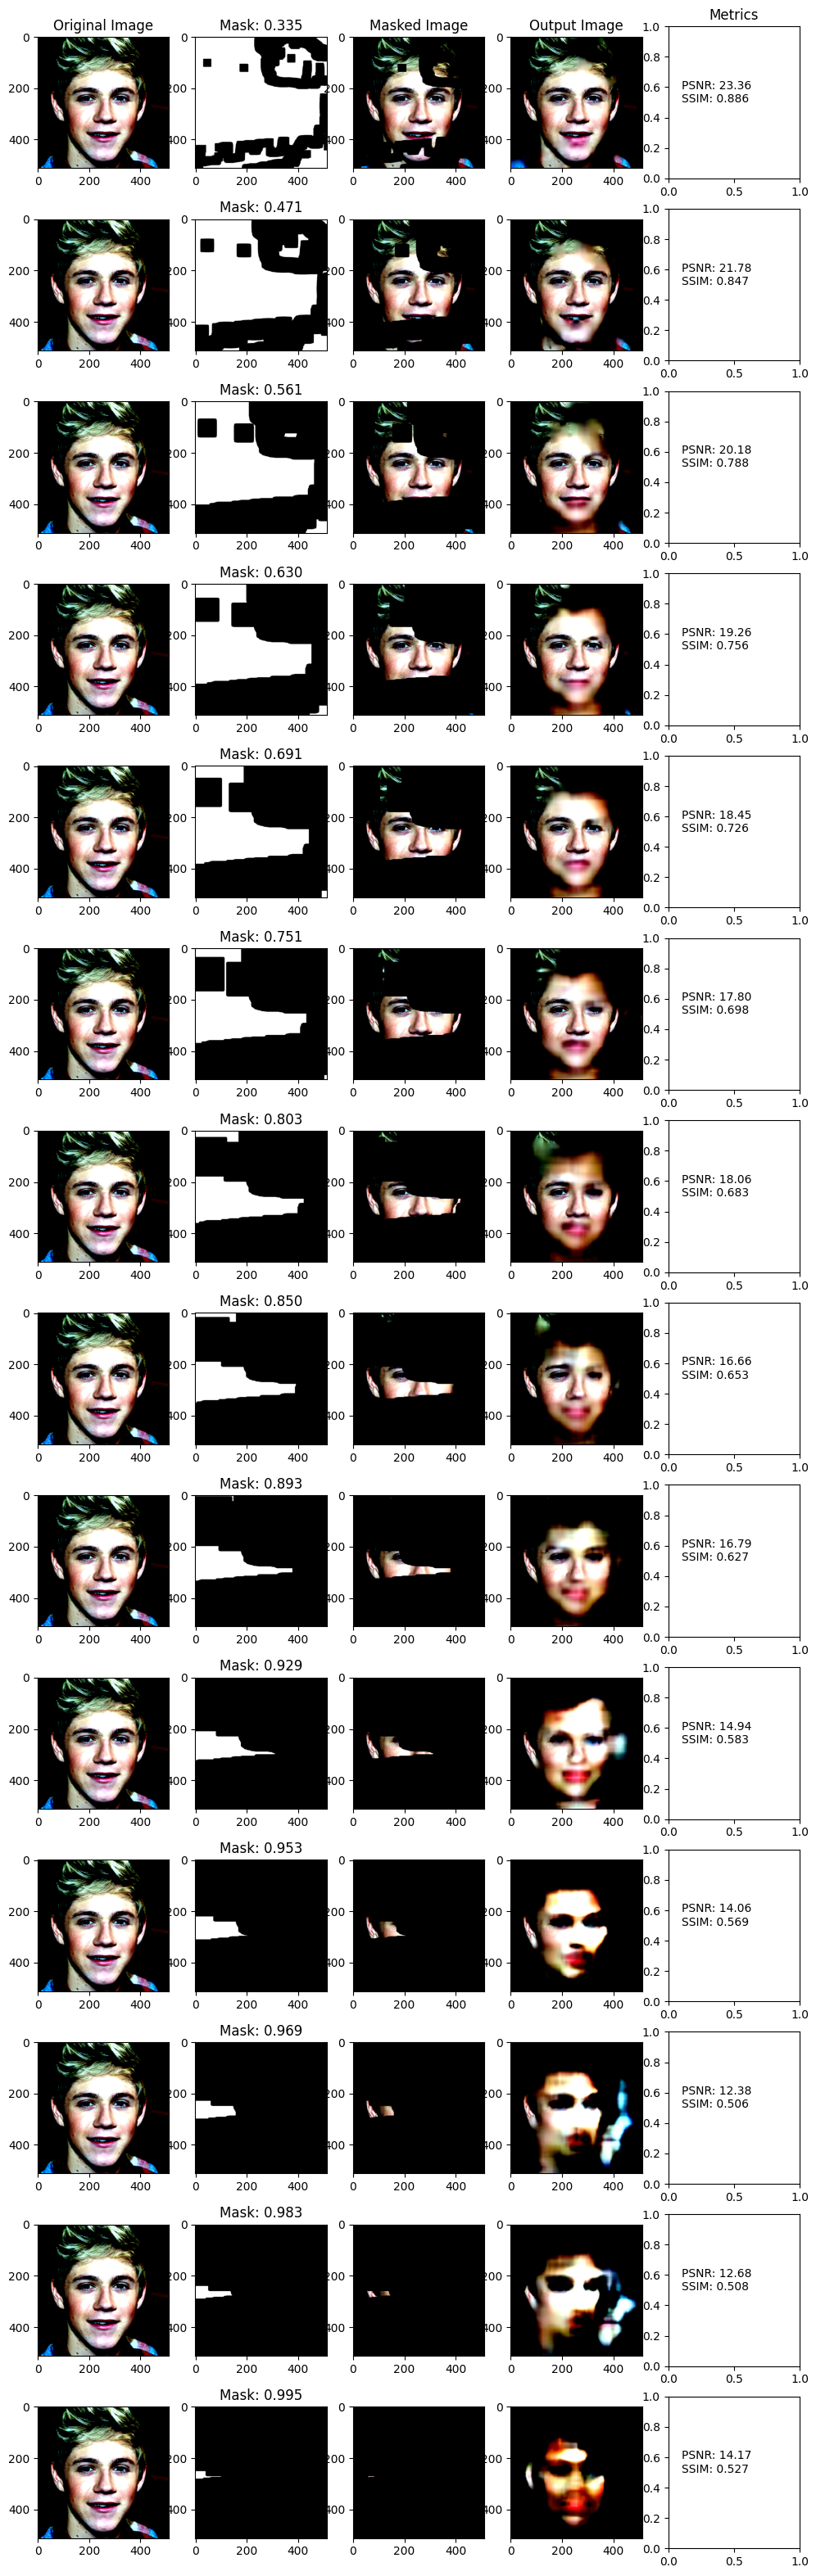

In [47]:
f = plt.figure(figsize=(12, 40))

n_imgs = len(data)
cols = 5

temp_img = imgs[img_idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()

for idx, (key, val) in enumerate(data.items()):
    # print(val['mask'].shape, val['out'].shape)
    temp_mask = val['mask'][0].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_out = val['out'][0].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    # print(temp_mask.shape, temp_out.shape)
    plt.subplot(n_imgs, cols, cols*idx+1)
    if idx == 0:
        plt.title("Original Image")
    plt.imshow(temp_img)

    plt.subplot(n_imgs, cols, cols*idx+2)
    if idx >= 0:
        plt.title(f"Mask: {key:.3f}")
    plt.imshow(temp_mask)

    plt.subplot(n_imgs, cols, cols*idx+3)
    if idx == 0:
        plt.title("Masked Image")
    plt.imshow(temp_mask * temp_img)

    plt.subplot(n_imgs, cols, cols*idx+4)
    if idx == 0:
        plt.title("Output Image")
    plt.imshow(temp_out)
    
    psnr = peak_signal_noise_ratio(normalize(temp_img), normalize(temp_out), data_range=1)
    ssim = structural_similarity(normalize(temp_img), normalize(temp_out), channel_axis=2, data_range=1)
    ax = plt.subplot(n_imgs, cols, cols*idx+5)
    if idx == 0:
        plt.title("Metrics")
    ax.text(0.1, 0.5, f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")

plt.show()

## Progressive Model

In [56]:
imgs, masks = next(iter(loader_test)).to(device), next(iter(mask_loader_test)).to(device)

In [57]:
img_idx = 1
img = imgs[img_idx].unsqueeze(0)
mask = masks[img_idx].unsqueeze(0)


data = {}
N, C, H, W = imgs.shape

while True:
    mask_per = (torch.sum(mask) / (C * H * W)).item()
    print("Mask Percentage: ", mask_per)

    out = model(img, mask)
    data[mask_per] = {}
    data[mask_per]['mask'] = mask.detach()
    data[mask_per]['out'] = out.detach()
    data[mask_per]['img'] = img.detach()

    kernel_size = 21
    kernel = torch.ones((C, 1, kernel_size, kernel_size)).to(device)
    mask_dilate = F.conv2d(input=mask, weight=kernel, padding=kernel_size//2, groups=C)
    mask = torch.clamp(mask_dilate, 0, 1)
    img = out

    if mask_per > 0.99:
        break

Mask Percentage:  0.7529608011245728
Mask Percentage:  0.8757596015930176
Mask Percentage:  0.9615802764892578
Mask Percentage:  0.9987937211990356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

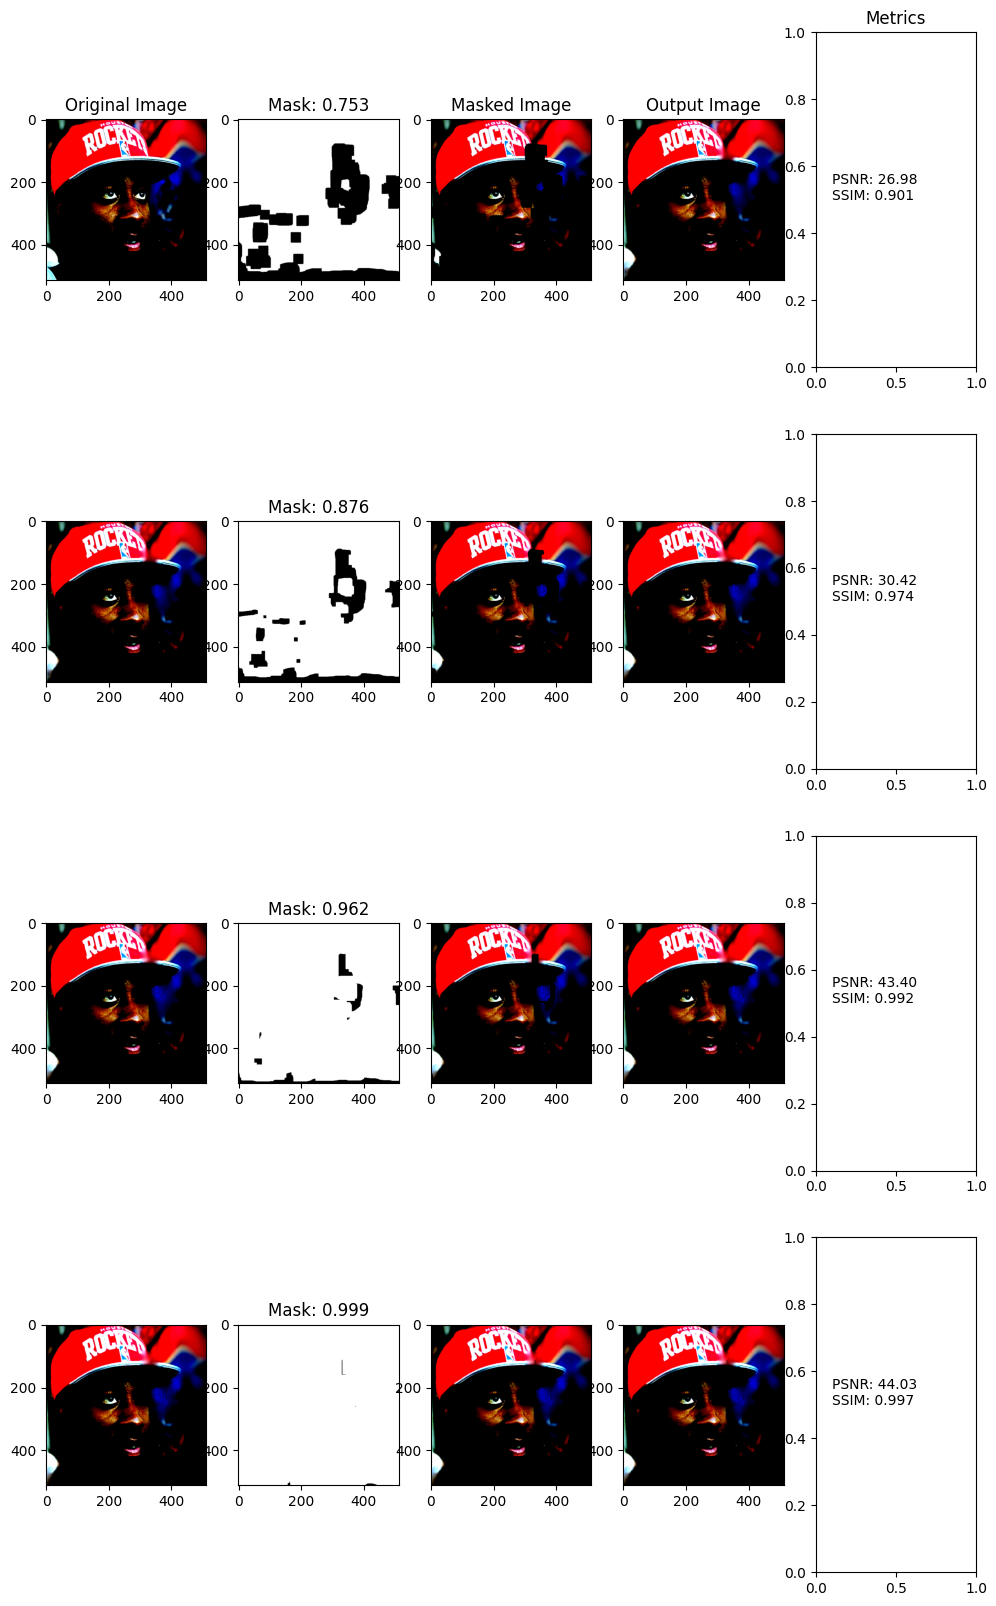

In [58]:
f = plt.figure(figsize=(12, 20))

n_imgs = len(data)
cols = 5

for idx, (key, val) in enumerate(data.items()):
    # print(val['mask'].shape, val['out'].shape)
    temp_img = val['img'][0].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_mask = val['mask'][0].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    temp_out = val['out'][0].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    # print(temp_mask.shape, temp_out.shape)
    plt.subplot(n_imgs, cols, cols*idx+1)
    if idx == 0:
        plt.title("Original Image")
    plt.imshow(temp_img)

    plt.subplot(n_imgs, cols, cols*idx+2)
    if idx >= 0:
        plt.title(f"Mask: {key:.3f}")
    plt.imshow(temp_mask)

    plt.subplot(n_imgs, cols, cols*idx+3)
    if idx == 0:
        plt.title("Masked Image")
    plt.imshow(temp_mask * temp_img)

    plt.subplot(n_imgs, cols, cols*idx+4)
    if idx == 0:
        plt.title("Output Image")
    plt.imshow(temp_out)

    psnr = peak_signal_noise_ratio(normalize(temp_img), normalize(temp_out), data_range=1)
    ssim = structural_similarity(normalize(temp_img), normalize(temp_out), channel_axis=2, data_range=1)
    ax = plt.subplot(n_imgs, cols, cols*idx+5)
    if idx == 0:
        plt.title("Metrics")
    ax.text(0.1, 0.5, f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")